# Object Detection Example

## Introduction

In this notebook, we'll walk through a detailed example of how you can use Valor to evaluate object detections made on [the COCO Panoptic dataset](https://cocodataset.org/#home). We'll use Ultralytics' `YOLOv8` model to predict what objects exist in various COCO photographs and compare performance between bounding box and image segmentation results.

For a conceptual introduction to Valor, [check out our project overview](https://striveworks.github.io/valor/). For a higher-level example notebook, [check out our "Getting Started" notebook](https://github.com/Striveworks/valor/blob/main/examples/getting_started.ipynb).

Before using this notebook, please ensure that the Valor service is running on your machine (for start-up instructions, [click here](https://striveworks.github.io/valor/getting_started/)). To connect to a non-local instance of Valor, update `client = Client("http://0.0.0.0:8000")` in the first code block to point to the correct URL.

## Defining Our Datasets

We start by fetching our dataset and uploading it to Valor.

In [1]:
%matplotlib inline

import os
import json
import builtins
import requests

from tqdm import tqdm
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

from valor_lite.detection import DataLoader, MetricType

The modules included in `./integrations` are helper modules that demonstrate how to ingest datasets and model inferences into Valor. The depth of each integration varies depending on the use case. 

The `coco_integration` is designed to download, extract, and upload all in one command as you are starting off with all the the data. 

The `yolo_integration` is much simpler; it is a collection of parser functions that convert YOLO model results into Valor types.

In [2]:
def download_data_if_not_exists(
    file_name: str,
    file_path: Path,
    url: str,
):
    """Download the data from a public bucket if it doesn't exist locally."""

    if not os.path.exists(file_path):
        response = requests.get(url, stream=True)
        if response.status_code == 200:
            total_size = int(response.headers.get("content-length", 0))
            with open(file_path, "wb") as f:
                with tqdm(
                    total=total_size,
                    unit="B",
                    unit_scale=True,
                    unit_divisor=1024,
                    desc=file_name,
                ) as pbar:
                    for chunk in response.iter_content(chunk_size=1024):
                        if chunk:
                            f.write(chunk)
                            pbar.update(1024)
        else:
            raise RuntimeError(response)
    else:
        print(f"{file_name} already exists locally.")

    # sort file by datum uid
    with open(file_path, "r") as f:
        lines = [x for x in f]
    with open(file_path, "w") as f:
        for line in sorted(
            lines, key=lambda x: int(json.loads(x)["datum"]["uid"])
        ):
            f.write(line)

groundtruth_file = "gt_objdet_coco_bbox.jsonl"
prediction_file = "pd_objdet_yolo_bbox.jsonl"

# cache data locally
current_directory = Path(os.getcwd())
for filename in [groundtruth_file, prediction_file]:
    file_path = current_directory / Path(filename)
    url = f"https://pub-fae71003f78140bdaedf32a7c8d331d2.r2.dev/{filename}"
    download_data_if_not_exists(
        file_name=filename, file_path=file_path, url=url
    )

gt_path = current_directory / Path(groundtruth_file)
pd_path = current_directory / Path(prediction_file)

gf = builtins.open(gt_path, "r")
groundtruths = [
    json.loads(gline)
    for gline in gf
]
gf.close()

pf = builtins.open(pd_path, "r")
predictions = [
    json.loads(pline)
    for pline in pf
]
pf.close()

gt_objdet_coco_bbox.jsonl already exists locally.
pd_objdet_yolo_bbox.jsonl already exists locally.


# Creating an Evaluator

This block utilizes `get_instance_groundtruths` from `integrations/coco_integration.py` to download, extract, and upload the COCO Panoptic validation dataset to Valor.

In [3]:
loader = DataLoader()
loader.add_bounding_boxes_from_valor_dict(zip(groundtruths, predictions), show_progress=True)
evaluator = loader.finalize()

5000it [00:00, 5835.58it/s]


In [4]:
evaluator.metadata

{'n_datums': 5000,
 'n_groundtruths': 36536,
 'n_predictions': 27092,
 'n_labels': 94,
 'ignored_prediction_labels': [],
 'missing_prediction_labels': [('supercategory', 'person'),
  ('supercategory', 'accessory'),
  ('iscrowd', '0'),
  ('supercategory', 'furniture'),
  ('supercategory', 'electronic'),
  ('supercategory', 'kitchen'),
  ('supercategory', 'appliance'),
  ('supercategory', 'food'),
  ('supercategory', 'indoor'),
  ('supercategory', 'animal'),
  ('iscrowd', '1'),
  ('supercategory', 'vehicle'),
  ('supercategory', 'outdoor'),
  ('supercategory', 'sports'),
  ('name', 'hair drier')]}

## Evaluating Performance

With our `Dataset` and `Model` defined, we're ready to evaluate our performance and display the results. Note that we use the `wait_for_completion` method since all evaluations run as background tasks; this method ensures that the evaluation finishes before we display the results.

Sometimes, we may only want to calculate metrics for a subset of our data (i.e., we may only want to see how well our model performed at a specific type of detection). To accomplish this task, we can use the `filters` parameter of `evaluation_detection` to specify what types of data to evaluate performance for.

We will be running and comparing two different evaluations investigating the performance difference of YOLOv8's bounding box and raster outputs.

In [5]:
metrics = evaluator.evaluate(
    iou_thresholds=[0.25],
)

### Average Precision (AP)

In [6]:
metrics[MetricType.AP]

[AP(value=0.0, iou_threshold=0.25, label=('supercategory', 'person')),
 AP(value=0.03931711480949181, iou_threshold=0.25, label=('name', 'person')),
 AP(value=0.0, iou_threshold=0.25, label=('iscrowd', '0')),
 AP(value=0.0, iou_threshold=0.25, label=('supercategory', 'furniture')),
 AP(value=0.00574667500702136, iou_threshold=0.25, label=('name', 'chair')),
 AP(value=0.012869301715994604, iou_threshold=0.25, label=('name', 'potted plant')),
 AP(value=0.12468056653228336, iou_threshold=0.25, label=('name', 'dining table')),
 AP(value=0.0, iou_threshold=0.25, label=('supercategory', 'electronic')),
 AP(value=0.025555256805287804, iou_threshold=0.25, label=('name', 'tv')),
 AP(value=0.0, iou_threshold=0.25, label=('supercategory', 'appliance')),
 AP(value=0.0873892652423137, iou_threshold=0.25, label=('name', 'microwave')),
 AP(value=0.07156154587928347, iou_threshold=0.25, label=('name', 'refrigerator')),
 AP(value=0.0, iou_threshold=0.25, label=('supercategory', 'indoor')),
 AP(value=0.

### Mean Average Precision (mAP)

In [7]:
metrics[MetricType.mAP]

[mAP(value=-1.0, iou_threshold=0.25, label_key='supercategory'),
 mAP(value=0.049578458401377326, iou_threshold=0.25, label_key='name'),
 mAP(value=-1.0, iou_threshold=0.25, label_key='iscrowd')]

### Precision-Recall Curve

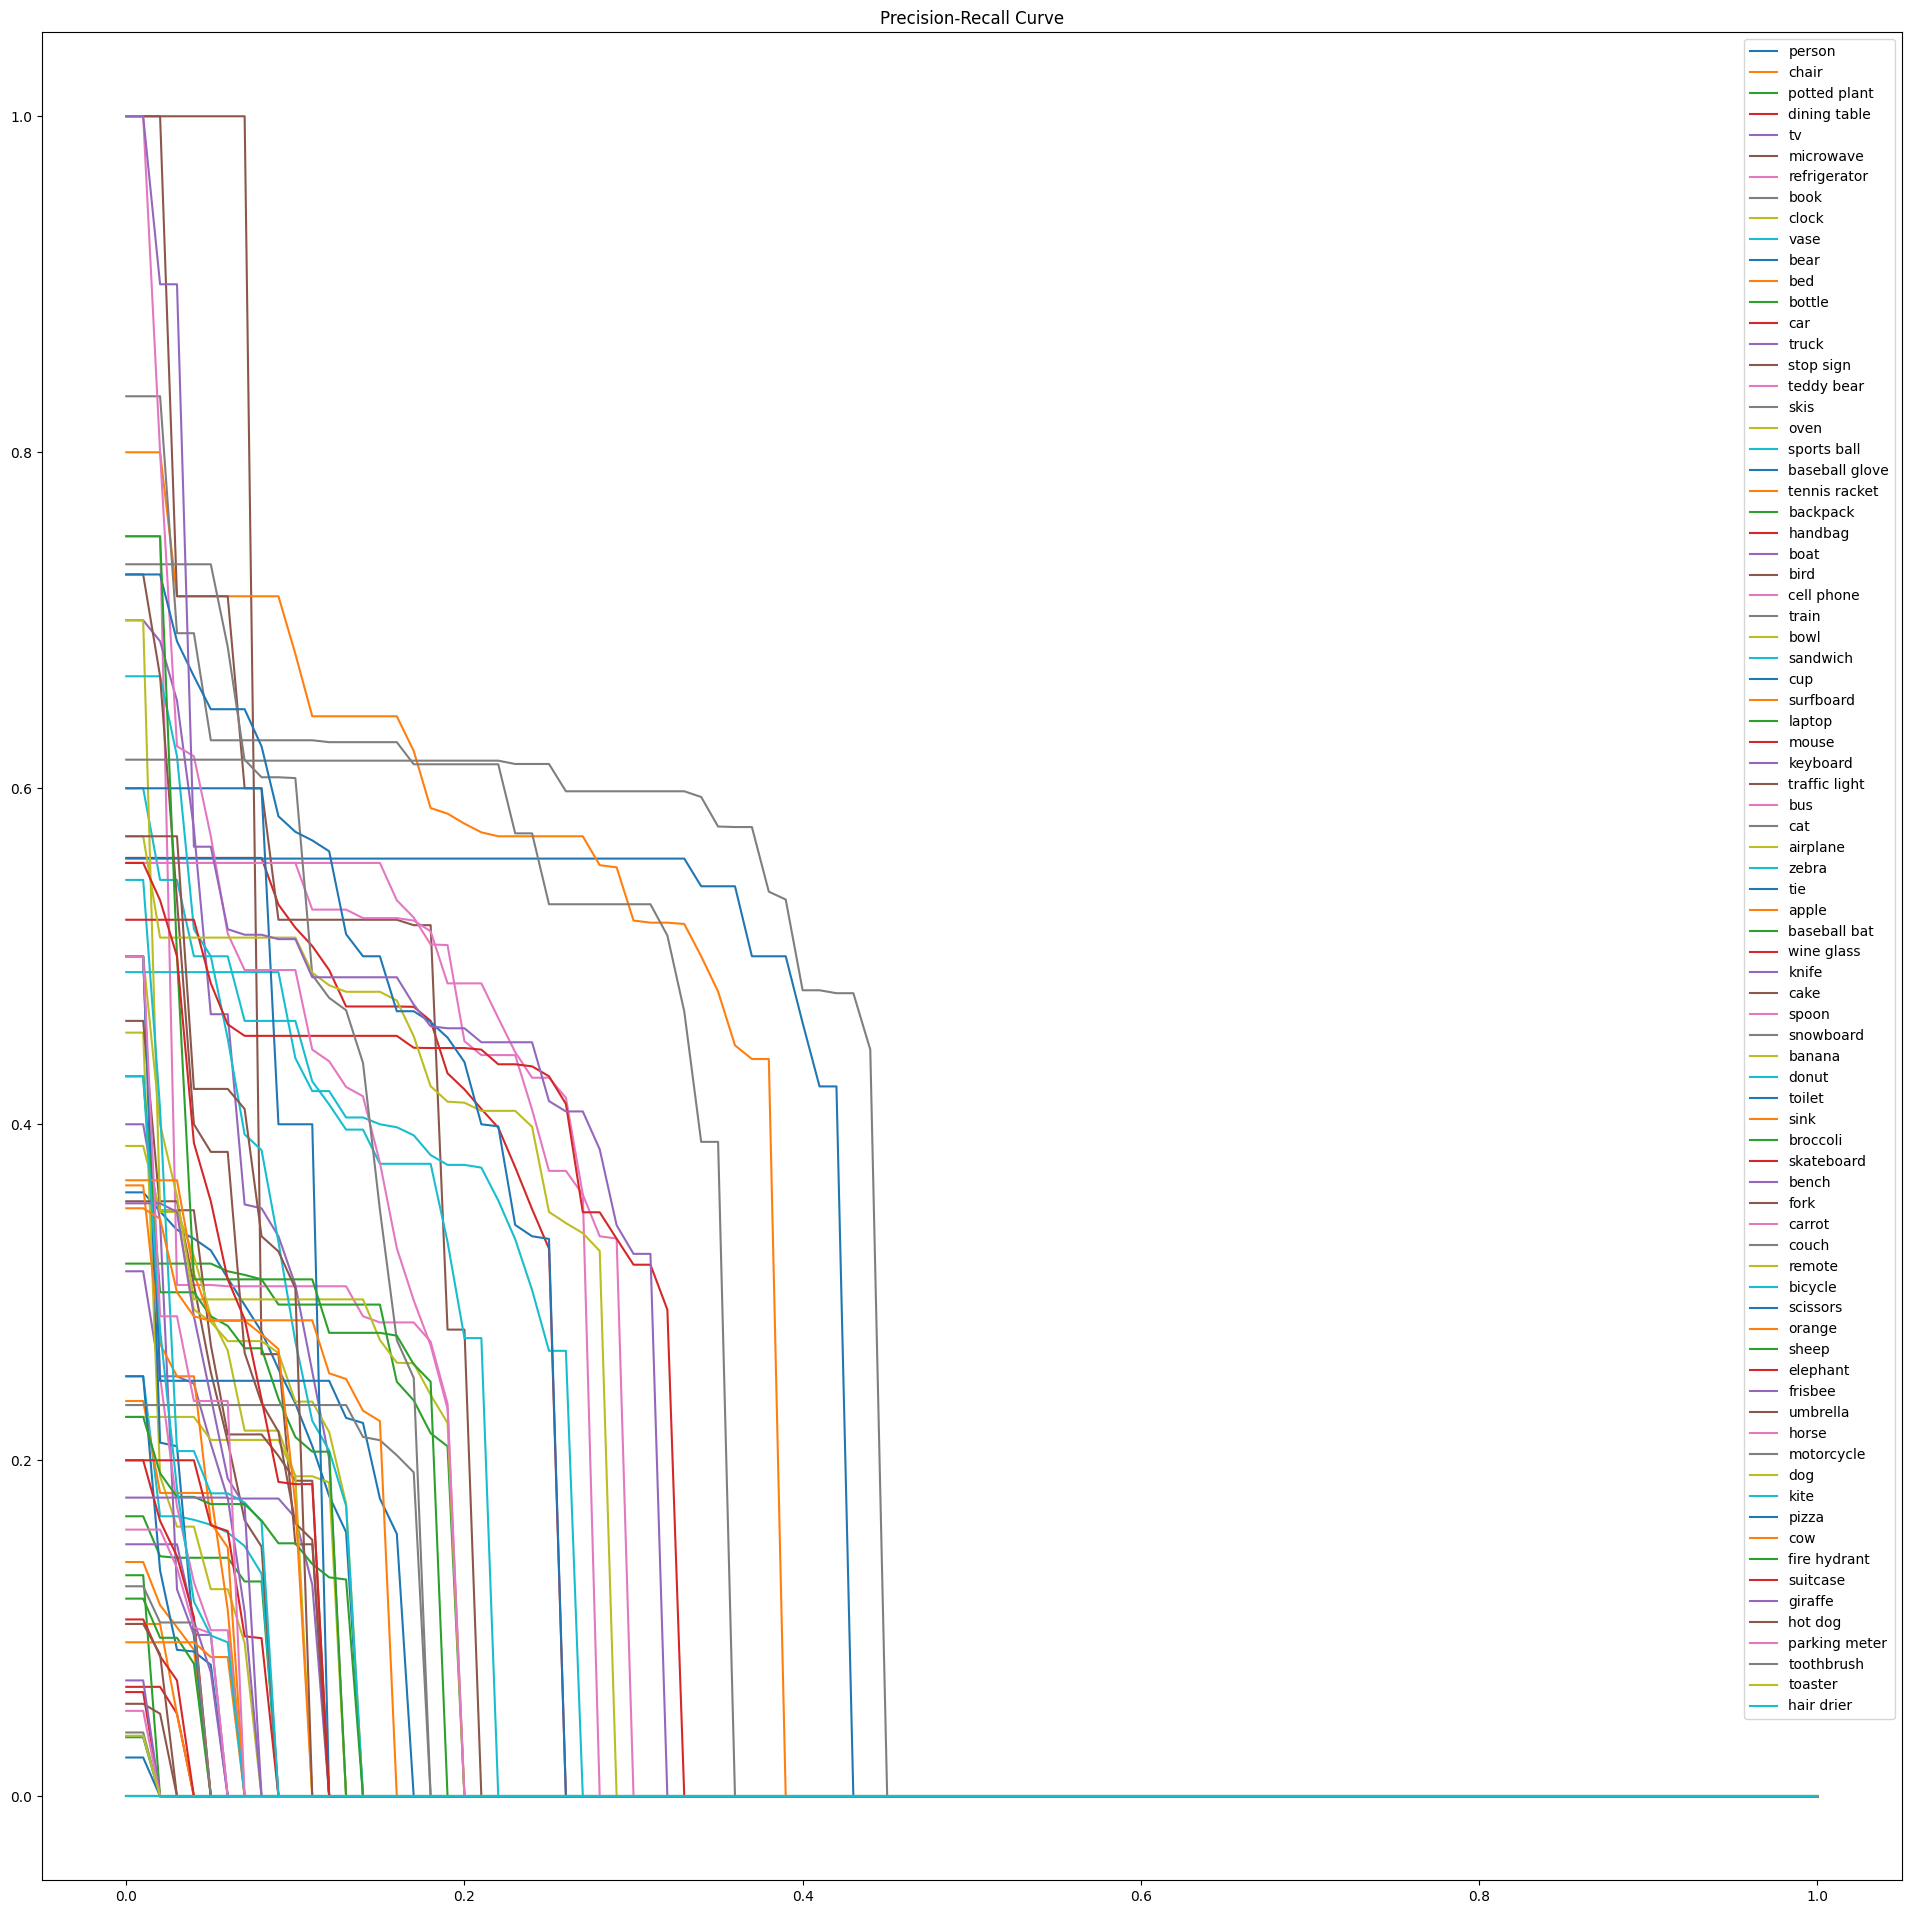

In [8]:
plt.rcParams['figure.figsize'] = [24, 24]
plt.figure()
recall = [x / 100 for x in range(0,101)]
for curve in metrics[MetricType.PrecisionRecallCurve]:
    if curve.label[0] != "name":
        continue
    plt.plot(recall, curve.precision, label=curve.label[1])
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

### Confusion Matrix

In [9]:
metrics = evaluator.evaluate(
    score_thresholds=[0.25],
    iou_thresholds=[0.25],
    metrics_to_return=[MetricType.ConfusionMatrix]
)[MetricType.ConfusionMatrix]
metric = [m for m in metrics if m.label_key == 'name'][0]

In [10]:
cm = {
    gt: {
        pd: metric.confusion_matrix[gt][pd]["count"]
        for pd in metric.confusion_matrix[gt]
    }
    for gt in metric.confusion_matrix
}
pd.DataFrame(cm)

,person,chair,potted plant,dining table,tv,microwave,refrigerator,book,clock,vase,...,pizza,cow,fire hydrant,suitcase,giraffe,hot dog,parking meter,toothbrush,toaster,hair drier
person,1718,23,4,35,3,0,0,2,0,1,...,9,2,1,4,0,4,0,1,0,1
chair,11,97,2,5,3,0,0,1,0,1,...,1,0,0,1,0,0,0,0,0,0
potted plant,1,4,31,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
dining table,35,7,3,186,1,0,0,1,0,0,...,4,0,0,0,0,1,0,0,0,0
tv,2,3,0,0,35,1,1,3,2,1,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
hot dog,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,13,0,0,0,0
parking meter,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,4,0,0,0
toothbrush,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
toaster,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Hallucinations

In [11]:
metric.hallucinations

{'person': {'count': 7483, 'examples': []},
 'chair': {'count': 837, 'examples': []},
 'potted plant': {'count': 199, 'examples': []},
 'dining table': {'count': 245, 'examples': []},
 'tv': {'count': 207, 'examples': []},
 'microwave': {'count': 41, 'examples': []},
 'refrigerator': {'count': 75, 'examples': []},
 'book': {'count': 220, 'examples': []},
 'clock': {'count': 213, 'examples': []},
 'vase': {'count': 162, 'examples': []},
 'bear': {'count': 37, 'examples': []},
 'bed': {'count': 52, 'examples': []},
 'bottle': {'count': 594, 'examples': []},
 'car': {'count': 1375, 'examples': []},
 'truck': {'count': 189, 'examples': []},
 'stop sign': {'count': 45, 'examples': []},
 'teddy bear': {'count': 73, 'examples': []},
 'skis': {'count': 143, 'examples': []},
 'oven': {'count': 76, 'examples': []},
 'sports ball': {'count': 169, 'examples': []},
 'baseball glove': {'count': 103, 'examples': []},
 'tennis racket': {'count': 177, 'examples': []},
 'backpack': {'count': 114, 'examp

### Ground Truths Missing Predictions

In [12]:
metric.missing_predictions

{'person': {'count': 9150, 'examples': []},
 'chair': {'count': 1621, 'examples': []},
 'potted plant': {'count': 304, 'examples': []},
 'dining table': {'count': 471, 'examples': []},
 'tv': {'count': 232, 'examples': []},
 'microwave': {'count': 47, 'examples': []},
 'refrigerator': {'count': 98, 'examples': []},
 'book': {'count': 1128, 'examples': []},
 'clock': {'count': 243, 'examples': []},
 'vase': {'count': 238, 'examples': []},
 'bear': {'count': 40, 'examples': []},
 'bed': {'count': 91, 'examples': []},
 'bottle': {'count': 984, 'examples': []},
 'car': {'count': 1829, 'examples': []},
 'truck': {'count': 327, 'examples': []},
 'stop sign': {'count': 60, 'examples': []},
 'teddy bear': {'count': 118, 'examples': []},
 'skis': {'count': 234, 'examples': []},
 'oven': {'count': 115, 'examples': []},
 'sports ball': {'count': 257, 'examples': []},
 'baseball glove': {'count': 139, 'examples': []},
 'tennis racket': {'count': 204, 'examples': []},
 'backpack': {'count': 347, 'e